import packages and libraries

In [1]:
import pandas as pd
import os
import pickle

take dataset and shuffle.

In [3]:
from sklearn.utils import shuffle

file_path = '../Sup/datset_fin.csv'
dataset = pd.read_csv(file_path,header=None)
dataset = shuffle(dataset)
dataset.head()

,0,1,2
171,The most infamous of his movies being Ghosts C...,DIRECTING#PERFORMANCE,Negative
1359,His character in the movie is so annoying,CAST#PERFORMANCE,Negative
1845,Leonardo DiCaprio and Kate Winslet have great ...,CAST#PERFORMANCE,Positive
1790,Billy Zane gives the film's best performance a...,CAST#PERFORMANCE,Positive
1223,scene shotted horribly,DIRECTING#PERFORMANCE,Negative


inspect the dataset.

In [4]:
data = dataset[0]
data.head()

171     The most infamous of his movies being Ghosts C...
1359            His character in the movie is so annoying
1845    Leonardo DiCaprio and Kate Winslet have great ...
1790    Billy Zane gives the film's best performance a...
1223                               scene shotted horribly
Name: 0, dtype: object

In [5]:
label_cat = dataset[1]
label_cat.unique()

array(['DIRECTING#PERFORMANCE', 'CAST#PERFORMANCE'], dtype=object)

start nlp pipeline

In [6]:
import spacy
nlp = spacy.load('en_core_web_sm')

preprocess the dataset the optimize the outputs.

In [7]:
data = data.str.lower()
aspect_terms = []
for review in nlp.pipe(data):
    chunks = [chunk.root.text for chunk in review.noun_chunks if chunk.root.pos_ == 'NOUN']
    aspect_terms.append(' '.join(chunks))
dataset[3] = aspect_terms

In [7]:
dataset.head()

,0,1,2,3
921,one of the top most influential directors.,DIRECTING#PERFORMANCE,Positive,directors
53,"Uwe Boll is making a movie about Darfur,",DIRECTING#PERFORMANCE,Negative,movie
545,great acting performance,CAST#PERFORMANCE,Positive,performance
687,Fantastic. Under utilized Captain Marvel a bi...,CAST#PERFORMANCE,Positive,send man
933,Chaplin is one of the best directors of all time.,DIRECTING#PERFORMANCE,Positive,directors time


define the model

In [8]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(512, input_shape=(6000,), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Using TensorFlow backend.


label encode the dataset to feed numerical values

In [9]:
from keras.preprocessing.text import Tokenizer

vocab_size = 6000 # We set a maximum size for the vocabulary
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data)
aspect_tokeniz = pd.DataFrame(tokenizer.texts_to_matrix(dataset[3]))

split the dataset between train and validation datasets.

In [10]:
#from sklearn.preprocessing import LabelEncoder
#import numpy as np
#from keras.utils import to_categorical

#label_encoder = LabelEncoder()
#integer_category = label_encoder.fit_transform(label_cat)

label_cate = label_cat.apply(lambda x:0 if x=="DIRECTING#PERFORMANCE" else 0).values
aspect_tokenized = aspect_tokeniz.loc[:899,:]
test_X = aspect_tokeniz.loc[900:,:]

dummy_category = label_cate[:900]
test_y = label_cate[900:]

In [11]:
#history = model.fit(aspect_tokenized, dummy_category, epochs=20, verbose=1)

define visualization function.

In [12]:
import matplotlib.pylab as plt

def plot_var(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc , label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and validation accuracy')

    plt.figure()

    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

train the model.

0 899
2 887
Train on 899 samples, validate on 885 samples
Epoch 1/5
899/899 [==============================] - 1s 2ms/step - loss: 0.5078 - accuracy: 0.9922 - val_loss: 0.2814 - val_accuracy: 1.0000
Epoch 2/5
899/899 [==============================] - 0s 340us/step - loss: 0.1537 - accuracy: 1.0000 - val_loss: 0.0624 - val_accuracy: 1.0000

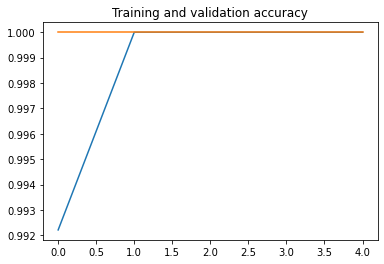

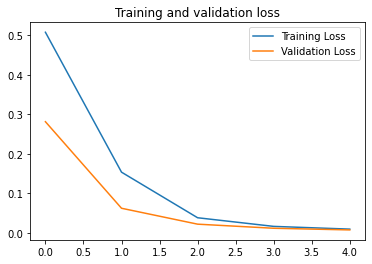

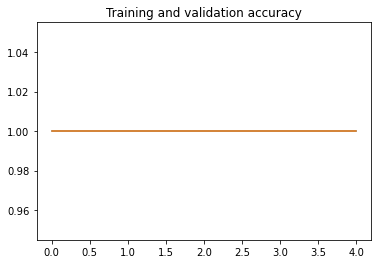

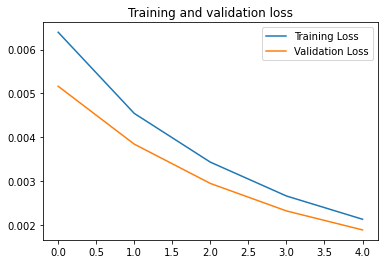

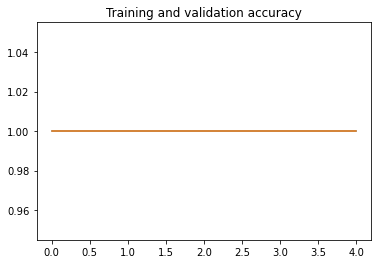

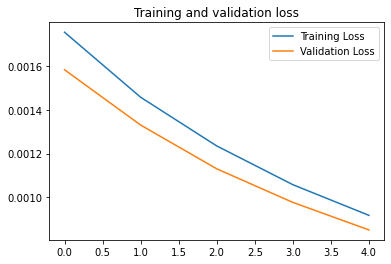

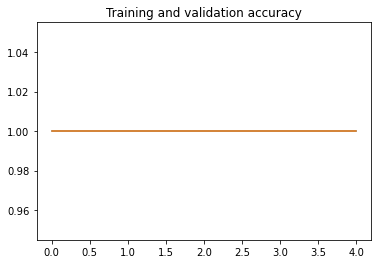

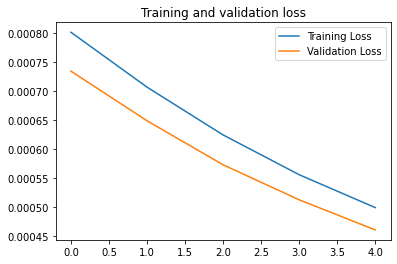

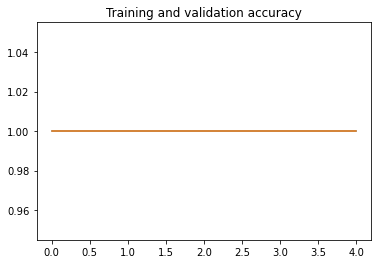

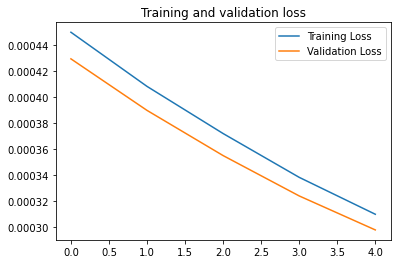

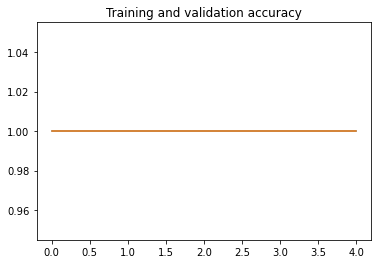

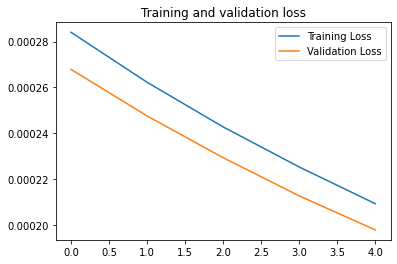

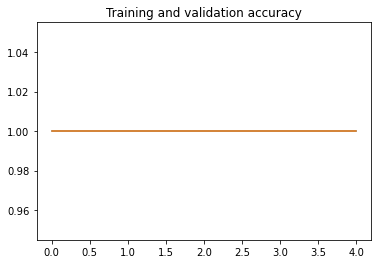

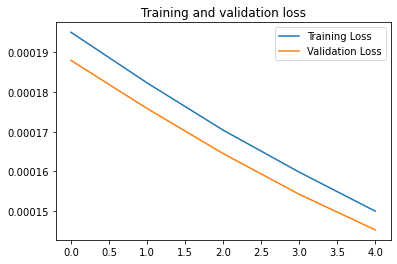

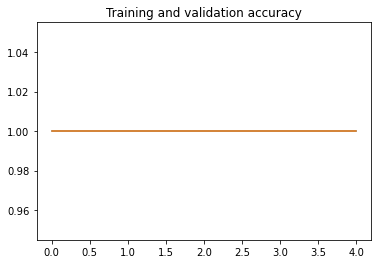

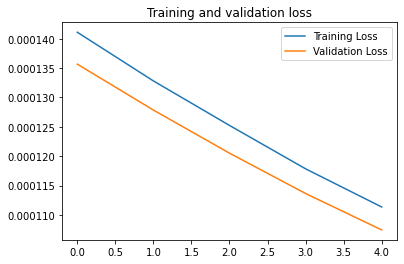

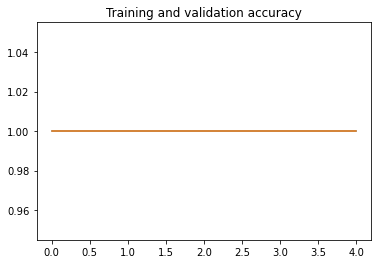

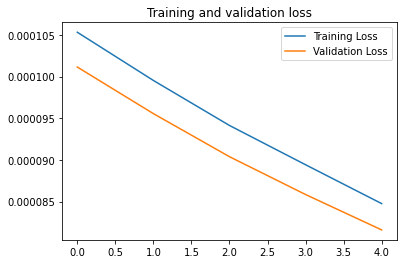

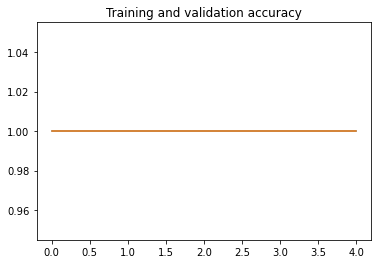

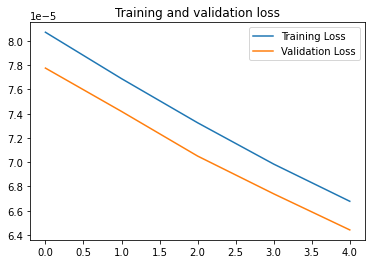

In [13]:
from sklearn.model_selection import KFold

cv = KFold(10,shuffle=True,random_state=1)
for train_ind,test_ind in cv.split(aspect_tokenized):
    print(train_ind[0],train_ind[-1])
    print(test_ind[0],test_ind[-1])
    train_start,train_end,test_start,test_end = train_ind[0],train_ind[-1],test_ind[0],test_ind[-1]
    X_train, X_test, y_train, y_test = aspect_tokenized.loc[train_start:train_end-1,:],\
                                       aspect_tokenized.loc[test_start:test_end-1,:], \
                                       dummy_category[train_start:train_end], \
                                       dummy_category[test_start:test_end]
    history = model.fit(X_train,y_train,epochs=5,verbose=1,validation_data=(X_test,y_test))
    plot_var(history)

model saving

In [14]:
model_save_path = '../Sup'
weight_save_path = '../Sup'
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)
if not os.path.exists(weight_save_path):
    os.mkdir(weight_save_path)
model.save( '../Sup/categorical_model_fin.h5')
model.save_weights( "../Sup/categorical_model_fin_weights.h5")

In [15]:
# saving
#if not os.path.exists('../Sup/tokenizer.pickle'):
#    os.mkdir('../Sup/tokenizer.pickle')
with open('../Sup/categorical_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


evaluate the model on the test set

In [16]:
logs = model.evaluate(test_X,test_y)
print(logs)

1102/1102 [==============================] - 0s 129us/step
[0.00010911263849800908, 1.0]
